Download Dataset

In [1]:
import os
import kagglehub

file_path = os.path.join(os.getcwd(), "datasets")
print("Dataset directory:", file_path)

if not os.path.exists(file_path) or not os.listdir(file_path):
    path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")
    print("Downloaded dataset to:", path)
else:
    print("Dataset already exists at:", file_path)
    print("Contents:", os.listdir(file_path))

Dataset directory: /content/datasets


100%|██████████| 1.76G/1.76G [00:44<00:00, 42.2MB/s]

Extracting files...


Downloaded dataset to: /root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.0 MB/s eta 0:00:00


Import required libraries

In [3]:
import tensorflow as tf
import keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import shutil
import tensorflow as tf

In [4]:
file_path = "/root/.cache/kagglehub/datasets/"
print(os.listdir(file_path))

['andrewmvd']


MV required dataset to the main_directory

In [5]:
lung_colon = os.path.join(
    file_path,
    "andrewmvd",
    "lung-and-colon-cancer-histopathological-images",
    "versions",
    "1",
    "lung_colon_image_set"
)
print(os.listdir(lung_colon))

['lung_image_sets', 'colon_image_sets']


In [ ]:
# ds = tf.keras.utils.image_dataset_from_directory(
#     lung_colon,
#     labels='inferred',
#     label_mode='categorical',
#     image_size=(224, 224),
#     batch_size=32
# )

# print("Detected class folders:", ds.class_names)
# print("Number of class folders:", len(ds.class_names))

Now map folders for their name

In [21]:
top_level_dirs = [d for d in os.listdir(lung_colon) if os.path.isdir(os.path.join(lung_colon, d))]
print("Top-level directories:", top_level_dirs)

# Now, list directories inside 'colon_image_sets'
colon_image_sets_path = os.path.join(lung_colon, "colon_image_sets")
colon_subdirs = [d for d in os.listdir(colon_image_sets_path) if os.path.isdir(os.path.join(colon_image_sets_path, d))]
print("Subdirectories in colon_image_sets:", colon_subdirs)


lung_image_sets = os.path.join(lung_colon, "lung_image_sets")
lung_subdirs = [d for d in os.listdir(lung_image_sets) if os.path.isdir(os.path.join(lung_image_sets, d))]
print("Subdirectories in lung_image_sets:", lung_subdirs)

classess = [lung_subdirs, colon_subdirs]
print("Classess:", classess)
class_labels = {
    "lung_aca": "Lung Adenocarcinoma",
    "lung_n": "Lung Benign Tissue (Normal)",
    "lung_scc": "Lung Squamous Cell Carcinoma",
    "colon_aca": "Colon Adenocarcinoma",
    "colon_n": "Colon Benign Tissue (Normal)"
}
print("Class labels:", class_labels)

Top-level directories: ['lung_image_sets', 'colon_image_sets']
Subdirectories in colon_image_sets: []
Subdirectories in lung_image_sets: []
Classess: [[], []]
Class labels: {'lung_aca': 'Lung Adenocarcinoma', 'lung_n': 'Lung Benign Tissue (Normal)', 'lung_scc': 'Lung Squamous Cell Carcinoma', 'colon_aca': 'Colon Adenocarcinoma', 'colon_n': 'Colon Benign Tissue (Normal)'}


In [22]:
import os
import shutil

flat_dir = "/app/datasets/lung_colon_flat"
os.makedirs(flat_dir, exist_ok=True)

for top in os.listdir(lung_colon):
    top_path = os.path.join(lung_colon, top)
    if os.path.isdir(top_path):
        for class_dir in os.listdir(top_path):
            class_path = os.path.join(top_path, class_dir)
            dest_path = os.path.join(flat_dir, class_dir)
            # Only move if it's a directory and not already moved
            if os.path.isdir(class_path) and not os.path.exists(dest_path):
                shutil.move(class_path, dest_path)

print("Flattened class folders:", os.listdir(flat_dir))


Flattened class folders: ['lung_aca', 'lung_n', 'colon_n', 'colon_aca', 'lung_scc']


Prepared Datasets for training

In [23]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

flat_dir = "/app/datasets/lung_colon_flat"

train_ds = tf.keras.utils.image_dataset_from_directory(
    flat_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    flat_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=123
)

class_names = train_ds.class_names
for n in train_ds.class_names:
    print([ord(c) for c in n], n)



def normalise(name: str) -> str:
    """
    • Removes any folder prefixes (basename)
    • Strips whitespace
    • Strips leading/trailing single or double quotes
    • Converts to lower-case
    """
    base   = os.path.basename(name)
    clean  = base.strip().strip("'\"").lower()
    return clean

readable_class_names = [
    class_labels.get(normalise(n), n)   # fallback → original
    for n in train_ds.class_names
]

print("Readable class names →", readable_class_names)

# If you want all downstream utilities (plots, confusion-matrix, etc.)
# to show the pretty labels, overwrite the attribute once:
train_ds.class_names = readable_class_names
val_ds.class_names   = readable_class_names


Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
[99, 111, 108, 111, 110, 95, 97, 99, 97] colon_aca
[99, 111, 108, 111, 110, 95, 110] colon_n
[108, 117, 110, 103, 95, 97, 99, 97] lung_aca
[108, 117, 110, 103, 95, 110] lung_n
[108, 117, 110, 103, 95, 115, 99, 99] lung_scc
Readable class names → ['Colon Adenocarcinoma', 'Colon Benign Tissue (Normal)', 'Lung Adenocarcinoma', 'Lung Benign Tissue (Normal)', 'Lung Squamous Cell Carcinoma']


In [26]:
# # for class_name in os.listdir(flat_dir):
# #     print(class_name)
# #     if class_name == "lung_aca":
# #         print(os.listdir(os.path.join(flat_dir, class_name)))

# print(readable_class_names)
# for r_names in readable_class_names:
#   print(os.listdir(r_names))

['Colon Adenocarcinoma', 'Colon Benign Tissue (Normal)', 'Lung Adenocarcinoma', 'Lung Benign Tissue (Normal)', 'Lung Squamous Cell Carcinoma']


FileNotFoundError: [Errno 2] No such file or directory: 'Colon Adenocarcinoma'

Build the CNN Model

In [27]:
from tensorflow.keras import layers, models

num_classes = len(readable_class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [28]:
EPOCHS = 12

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 120ms/step - accuracy: 0.6343 - loss: 0.8779 - val_accuracy: 0.8454 - val_loss: 0.3563
Epoch 2/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 106ms/step - accuracy: 0.8456 - loss: 0.3760 - val_accuracy: 0.7456 - val_loss: 0.5288
Epoch 3/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 119ms/step - accuracy: 0.8896 - loss: 0.2877 - val_accuracy: 0.9266 - val_loss: 0.1852
Epoch 4/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 109ms/step - accuracy: 0.9141 - loss: 0.2211 - val_accuracy: 0.9042 - val_loss: 0.2716
Epoch 5/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.9367 - loss: 0.1706 - val_accuracy: 0.9456 - val_loss: 0.1493
Epoch 6/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 119ms/step - accuracy: 0.9505 - loss: 0.1339 - val_accuracy: 0.9476 - val_loss: 0.1334
Epoch 7/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 106ms/step - accuracy: 0.9596 - loss: 0.1188 - val_accuracy: 0.9484 - val_loss: 0.1526
Epoch 8/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 120ms/step - accuracy: 0.9590 - loss: 0

In [29]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9648 - loss: 0.1277
Validation loss: 0.1376
Validation accuracy: 0.9616


In [30]:
model.save('my_cancer_cnn_model.h5')
!ls

my_cancer_cnn_model.h5	sample_data


In [31]:
!ls

my_cancer_cnn_model.h5	sample_data


In [32]:
import numpy as np

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    for i in range(len(images)):
        print(f"True: {class_names[true_classes[i]]}, Predicted: {class_names[pred_classes[i]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
True: lung_aca, Predicted: lung_aca
True: colon_aca, Predicted: colon_aca
True: lung_n, Predicted: lung_n
True: colon_n, Predicted: colon_n
True: colon_n, Predicted: colon_n
True: colon_aca, Predicted: colon_aca
True: lung_scc, Predicted: lung_aca
True: lung_aca, Predicted: lung_aca
True: lung_scc, Predicted: lung_scc
True: lung_n, Predicted: lung_n
True: colon_n, Predicted: colon_n
True: lung_n, Predicted: lung_n
True: colon_aca, Predicted: colon_aca
True: lung_scc, Predicted: lung_scc
True: lung_n, Predicted: lung_n
True: lung_n, Predicted: lung_n
True: lung_n, Predicted: lung_n
True: colon_n, Predicted: colon_n
True: lung_aca, Predicted: lung_aca
True: lung_aca, Predicted: lung_aca
True: lung_aca, Predicted: lung_aca
True: lung_scc, Predicted: lung_scc
True: lung_scc, Predicted: lung_aca
True: lung_aca, Predicted: lung_aca
True: lung_n, Predicted: lung_n
True: lung_n, Predicted: lung_n
True: lung_scc, Predicted: lung_scc
True: lung_n, Predicted

In [33]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/app/datasets/lung_colon_flat/lung_aca/lungaca2296.jpeg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # make batch of 1

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    f"Predicted class: {class_names[np.argmax(score)]}, Confidence: {100 * np.max(score):.2f}%"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
Predicted class: lung_aca, Confidence: 40.23%


In [34]:
!pip install Augmentor imageio
import Augmentor, imageio, glob

p = Augmentor.Pipeline("/app/datasets/lung_colon_flat/lung_aca")
p.rotate(probability=1, max_left_rotation=25, max_right_rotation=25)
p.sample(8)

output_dir = "/app/datasets/lung_colon_flat/lung_aca/output"
print(glob.glob(f"{output_dir}/*"))  # Debug: should list your images

frames = []
for img_file in sorted(glob.glob(f"{output_dir}/*")):
    frames.append(imageio.imread(img_file))
if frames:
    imageio.mimsave('/app/datasets/lung_colon_flat/augmentation.gif', frames, duration=0.5)
else:
    print("No images found to make a GIF.")

Initialised with 5000 image(s) found.
Output directory set to /app/datasets/lung_colon_flat/lung_aca/output.

Processing <PIL.Image.Image image mode=RGB size=768x768 at 0x7978B8FCD150>: 100%|██████████| 8/8 [00:00<00:00,  8.88 Samples/s]
<ipython-input-34-4100820162>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(img_file))


['/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca938.jpeg_cf90b811-efed-4cd7-aa74-fd0d411d38b5.jpeg', '/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca3194.jpeg_01563ff1-7c7e-495a-b1fa-ccbf622ae288.jpeg', '/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca209.jpeg_2d0bc405-a645-4ffd-8b36-27b7a10f233e.jpeg', '/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca323.jpeg_7911200d-0d99-4075-a6b4-89eea51ac564.jpeg', '/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca3217.jpeg_45568fda-d350-4ad0-9842-c9e1cc060f25.jpeg', '/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca3522.jpeg_989642f1-6d65-4589-aced-be0002a2a8dd.jpeg', '/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca4147.jpeg_7284c50e-7171-489e-87d9-b7597110af1e.jpeg', '/app/datasets/lung_colon_flat/lung_aca/output/lung_aca_original_lungaca4296.jpeg_cf3a84f1-cc5a-491f-86ce-4cbe00159850.j

In [ ]:
%pip install "numpy<2.2.0,>=1.26.0" --force-reinstall
%pip install --upgrade pip
%pip install --force-reinstall opencv-python


  Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (13.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.6 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 12.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.

In [35]:
# tells Keras: “this model will see batches of 224×224×3 images”
model.build((None, 224, 224, 3))
import numpy as np

# one “fake” image full of zeros
dummy = np.zeros((1, 224, 224, 3), dtype=np.float32)
_ = model.predict(dummy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [36]:
import tensorflow as tf
import numpy as np
import imageio

# 1. Pick one example image (H×W×C), e.g. first val sample:
for imgs, _ in val_ds.take(1):
    img = imgs[0].numpy().astype(np.uint8)
    break

# 2. Build a simple augmentation block:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# 3. Generate N augmentations and collect frames
frames = []
for _ in range(20):
    aug = data_augment(tf.expand_dims(img,0))[0].numpy().astype(np.uint8)
    frames.append(aug)

# 4. Write to GIF (will show up in your working dir)
imageio.mimsave("augmentation.gif", frames, fps=4)


In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/app/datasets/lung_colon_flat",
    labels="inferred",
    label_mode="categorical",
    image_size=(224,224),
    batch_size=32,
    validation_split=0.2,
    subset="both",
    seed=123
)
# after load or before extract:
model = tf.keras.models.load_model("my_cancer_cnn_model.h5")
model.build(input_shape=(None, 224, 224, 3))


Found 25008 files belonging to 5 classes.
Using 20007 files for training.
Using 5001 files for validation.


In [38]:
from tensorflow.keras import Input, Model
import shutil

# 1. Load your weights-only or unbuilt model
model = tf.keras.models.load_model("my_cancer_cnn_model.h5")

# 2. Create a new Functional graph
inp = Input(shape=(224,224,3), name="act_in")
x = inp
activation_outputs = []

# 3. Re-apply every layer, and whenever it's a Conv2D, capture its output
for layer in model.layers:
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv2D):
        activation_outputs.append(x)

# 4. Bundle into a single Model that goes from inp ⇒ [all conv outputs]
activation_model = Model(inputs=inp, outputs=activation_outputs)


In [39]:
# assume `img` from above is uint8 H×W×3
import tensorflow as tf
import imageio.v2 as imageio

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])
frames = []
for _ in range(20):
    a = augment(tf.expand_dims(img,0))[0].numpy().astype(np.uint8)
    frames.append(a)
imageio.mimsave("augmentation.gif", frames, fps=4)


In [ ]:
!ls

Dockerfile	  datasets		  notebooks	    run.sh
augmentation.gif  my_cancer_cnn_model.h5  requirements.txt


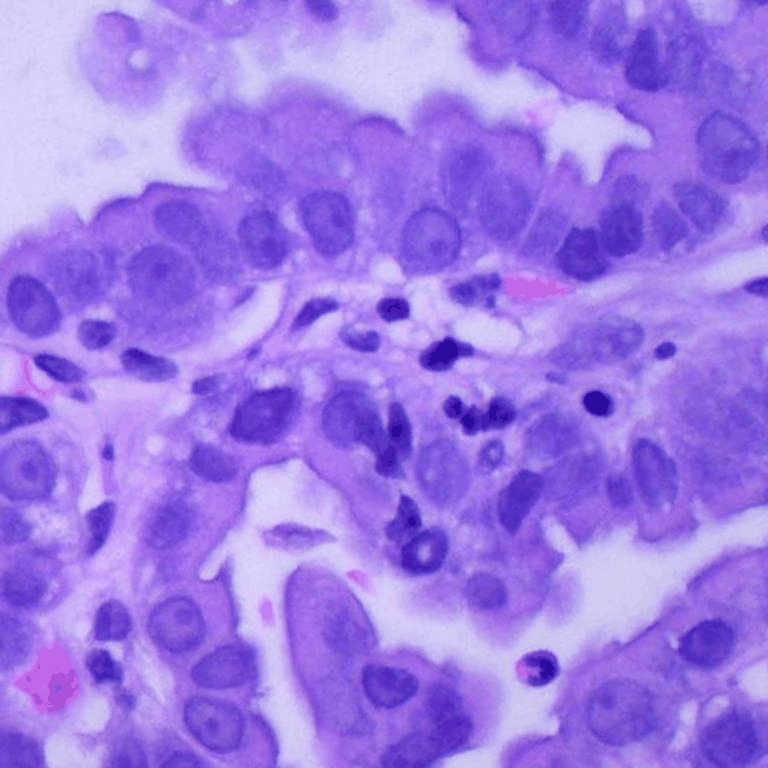

In [40]:
from IPython.display import Image, display

# adjust the path if yours lives elsewhere
gif_path = "/app/datasets/lung_colon_flat/augmentation.gif"
display(Image(filename=gif_path))